### **Goal of Clustering Techniques**:
The following Analysis focuses on applying different clustering methods (e.g. KMeans, Agglomerative Clustering) to perform employee segmentation, identifying distinct groups based on key characteristics. It further examines how these clusters are related to attrition, revealing insights into employee retention risks and uncovering opportunities for targeted HR strategies to improve retention.

In [223]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [290]:
df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
print("Initial data shape:", df.shape)

Initial data shape: (1470, 35)


In [291]:
df.head(2)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7


## **Clustering**: Customer Segementation

The goal of employee segmentation clustering is to group employees based on their inherent characteristics. Including attrition as a feature would bias the clustering process, making it treat 'Attrition' as one characteristic label rather than group them based on employee similarities naturally. By excluding attrition, we can discover meaningful patterns and identify high-risk groups without forcing the model to rely on prior labels.

### Data Information

In [292]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [293]:
df.isna().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

In [294]:
df.drop_duplicates(inplace=True)
print("After removing duplicates:", df.shape)

After removing duplicates: (1470, 35)


In [295]:
len(df[df['Over18']=='Y']) # Over18 has one unique value

1470

In [296]:
data = df.drop(columns = 'Attrition')
data = data.drop(columns = ['EmployeeNumber', 'EmployeeCount', 'Over18', 'StandardHours'])

### Feature Selection (Removing Redundant Variables)

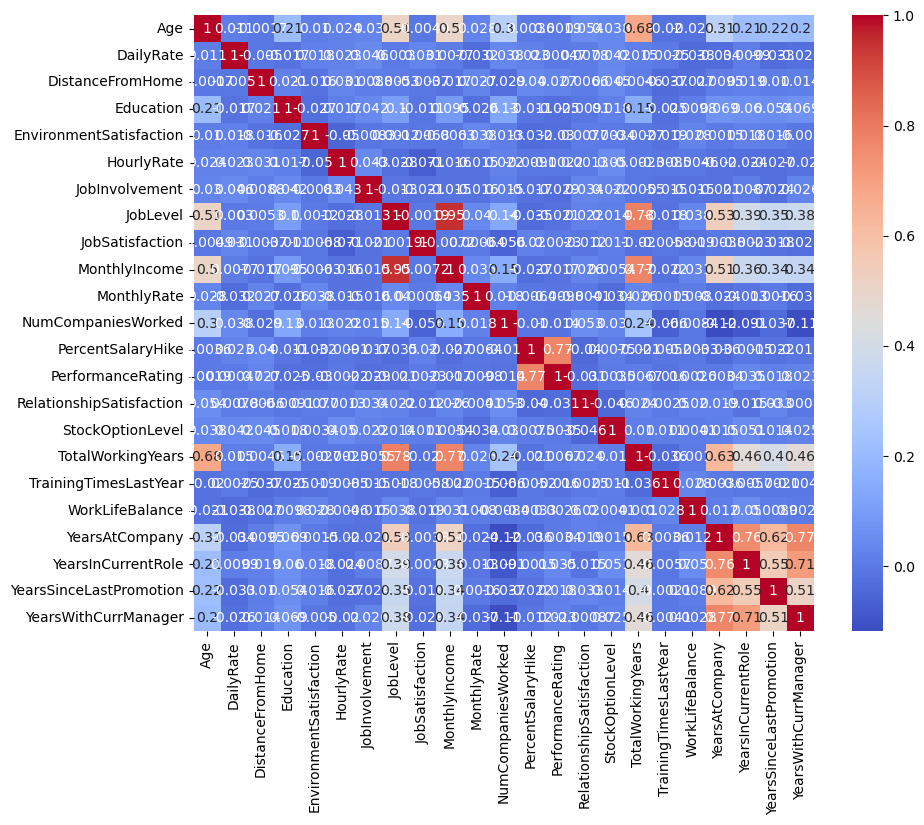

In [297]:
# Correlation
df_numeric = data.select_dtypes(include = np.number)
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df_numeric.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [298]:
# Income and Job Level are highly-correlated, once keep one
data = data.drop(columns = 'JobLevel')

In [299]:
data_numeric = data.select_dtypes(include = np.number)

skewness = data_numeric.skew()
skewed_columns = skewness[abs(skewness) > 1].index
print(skewed_columns)

Index(['MonthlyIncome', 'NumCompaniesWorked', 'PerformanceRating',
       'TotalWorkingYears', 'YearsAtCompany', 'YearsSinceLastPromotion'],
      dtype='object')


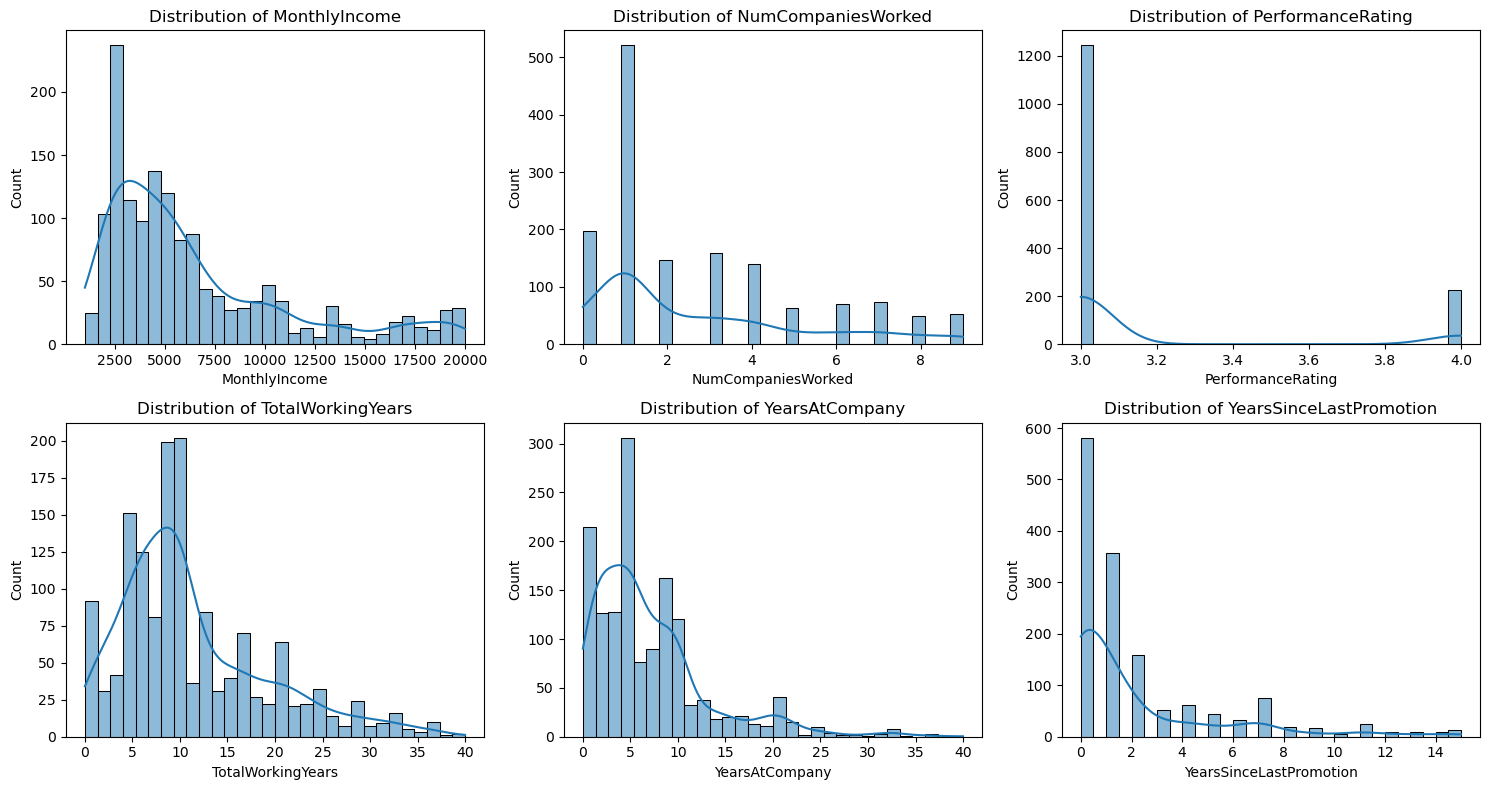

In [300]:
skewed_list = list(skewed_columns)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for i, col in enumerate(skewed_list):
    sns.histplot(data[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

In [301]:
data_log = data.copy()

for col in skewed_columns:
    data_log[col] = np.log1p(data_log[col])

In [302]:
cate_col = data_log.select_dtypes(include = 'object').columns.tolist()
print(cate_col)

data_log_encoded = pd.get_dummies(data_log, columns=cate_col, drop_first=True)
print(data_log_encoded.head(2))

['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
   Age  DailyRate  DistanceFromHome  Education  EnvironmentSatisfaction  \
0   41       1102                 1          2                        2   
1   49        279                 8          1                        3   

   HourlyRate  JobInvolvement  JobSatisfaction  MonthlyIncome  MonthlyRate  \
0          94               3                4       8.698514        19479   
1          61               2                2       8.543056        24907   

   ...  JobRole_Laboratory Technician  JobRole_Manager  \
0  ...                          False            False   
1  ...                          False            False   

   JobRole_Manufacturing Director  JobRole_Research Director  \
0                           False                      False   
1                           False                      False   

   JobRole_Research Scientist  JobRole_Sales Executive  \
0           

In [303]:
data_log_encoded_std = data_log_encoded.copy()

scaler = StandardScaler()
num_col = data_log_encoded.select_dtypes(include = ['int64', 'float64']).columns
data_log_encoded_std[num_col] = scaler.fit_transform(data_log_encoded_std[num_col])
print(data_log_encoded_std.head(2))

        Age  DailyRate  DistanceFromHome  Education  EnvironmentSatisfaction  \
0  0.446350   0.742527         -1.010909  -0.891688                -0.660531   
1  1.322365  -1.297775         -0.147150  -1.868426                 0.254625   

   HourlyRate  JobInvolvement  JobSatisfaction  MonthlyIncome  MonthlyRate  \
0    1.383138        0.379672         1.153254       0.219493     0.726020   
1   -0.240677       -1.026167        -0.660853      -0.014600     1.488876   

   ...  JobRole_Laboratory Technician  JobRole_Manager  \
0  ...                          False            False   
1  ...                          False            False   

   JobRole_Manufacturing Director  JobRole_Research Director  \
0                           False                      False   
1                           False                      False   

   JobRole_Research Scientist  JobRole_Sales Executive  \
0                       False                     True   
1                        True           

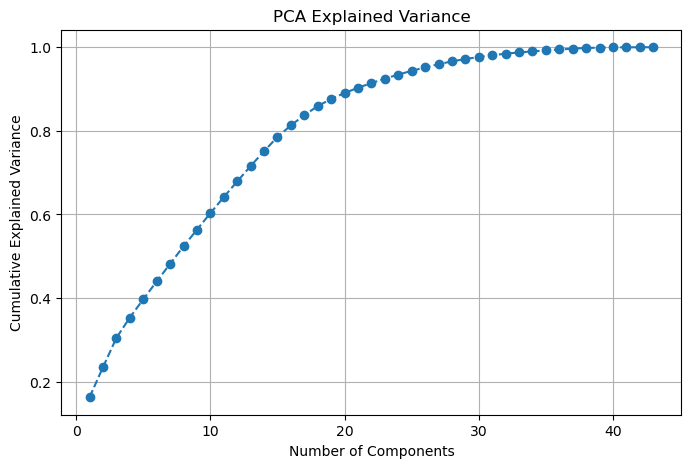

In [363]:
# Check Whether PCA will work well
pca = PCA()
data_log_encoded_std_pca = pca.fit_transform(data_log_encoded_std)

# Calculate Cumulative Explained Variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Visualize
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

In [365]:
pca = PCA(n_components=0.90)
data_log_encoded_std_pca = pca.fit_transform(data_log_encoded_std)# 获取原始特征名

print(f"Number of Features After PCA: {data_log_encoded_std_pca.shape[1]}")

Number of Features After PCA: 21


In [371]:
pca = PCA(n_components=0.90)
data_log_encoded_std_pca = pca.fit_transform(data_log_encoded_std)

feature_names = data_log_encoded_std.columns
pca_components = pd.DataFrame(pca.components_, columns=feature_names) 

top_features = []
for i in range(pca_components.shape[0]):  
    top_feature = pca_components.iloc[i].abs().idxmax()
    top_features.append(top_feature)

df_pca_named = pd.DataFrame(data_log_encoded_std_pca, columns=top_features)

print(df_pca_named.shape)
display(df_pca_named.head(2))

(1470, 21)


,YearsAtCompany,PerformanceRating,PercentSalaryHike,StockOptionLevel,JobSatisfaction,WorkLifeBalance,DistanceFromHome,EnvironmentSatisfaction,TrainingTimesLastYear,RelationshipSatisfaction,...,WorkLifeBalance,DistanceFromHome,HourlyRate,Education,NumCompaniesWorked,NumCompaniesWorked,YearsSinceLastPromotion,Age,EducationField_Life Sciences,BusinessTravel_Travel_Rarely
0,-0.086031,-1.601322,0.283356,0.149189,0.355501,-2.417656,1.480369,1.139395,0.485960,2.551032,...,1.838196,-1.105913,0.433634,0.517313,0.144145,1.408396,1.234789,0.930982,0.144664,-0.006141
1,1.098988,2.789668,1.582436,-1.281642,-0.013239,1.108357,0.338176,-1.437423,1.114696,-0.067496,...,-0.416155,-1.725943,0.083987,0.068751,-0.056478,-1.296319,0.087845,1.180763,0.786145,0.620385


In [380]:
df_pca = df_pca_named.copy()

In [381]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Try different k value
cluster_range = range(2, 7)
silhouette_scores_pca = {"K-Means": [], "GMM": [], "Agglomerative": [], "Spectral": []}

# Try K-Means、GMM、Agglomerative and Spectral Clustering
for k in cluster_range:
    # K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_clusters = kmeans.fit_predict(df_pca)
    kmeans_score = silhouette_score(df_pca, kmeans_clusters)
    silhouette_scores_pca["K-Means"].append(kmeans_score)

    # GMM
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm_clusters = gmm.fit_predict(df_pca)
    gmm_score = silhouette_score(df_pca, gmm_clusters)
    silhouette_scores_pca["GMM"].append(gmm_score)

    # Agglomerative
    agglo = AgglomerativeClustering(n_clusters=k)
    agglo_clusters = agglo.fit_predict(df_pca)
    agglo_score = silhouette_score(df_pca, agglo_clusters)
    silhouette_scores_pca["Agglomerative"].append(agglo_score)

    # Spectral Clustering
    spectral = SpectralClustering(n_clusters=k, random_state=42)
    spectral_clusters = spectral.fit_predict(df_pca)
    spectral_score = silhouette_score(df_pca, spectral_clusters)
    silhouette_scores_pca["Spectral"].append(spectral_score)

In [382]:
best_scores_pca = {
    "Best K-Means": max(silhouette_scores_pca["K-Means"]),
    "Best GMM": max(silhouette_scores_pca["GMM"]),
    "Best Agglomerative": max(silhouette_scores_pca["Agglomerative"]),
    "Best Spectral": max(silhouette_scores_pca["Spectral"]),
}

best_scores_pca

{'Best K-Means': 0.11347024896053307,
 'Best GMM': 0.09980688187997301,
 'Best Agglomerative': 0.09265200180034355,
 'Best Spectral': 0.12303682291768457}

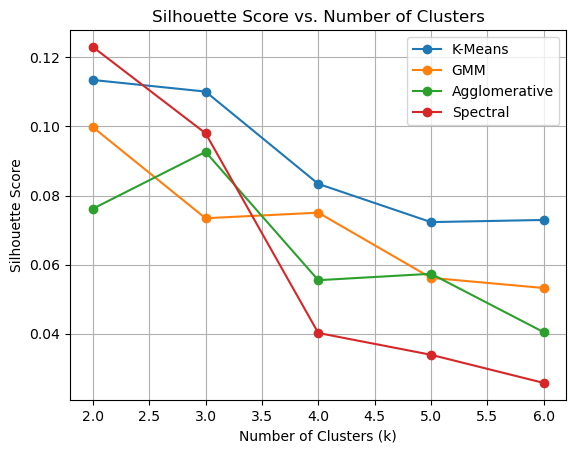

In [309]:
algorithms = ["K-Means", "GMM", "Agglomerative", "Spectral"]
for algo in algorithms:
    plt.plot(cluster_range, silhouette_scores_pca[algo], marker='o', label=algo)

plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. Number of Clusters")
plt.legend()
plt.grid(True)
plt.show()

## **KMeans Clustering**

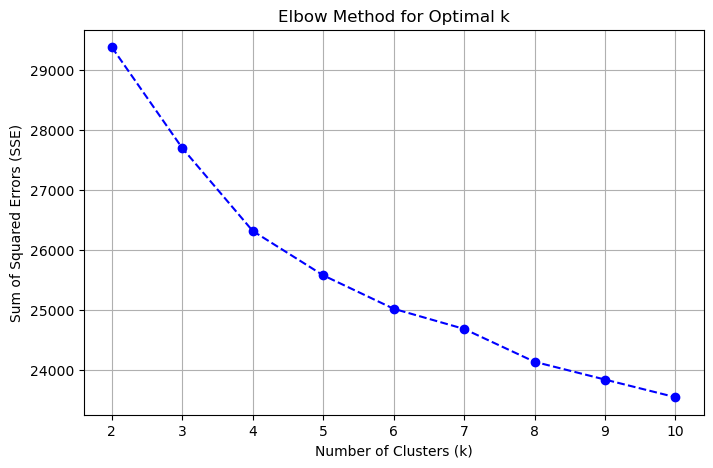

In [310]:
# Elbow Method to Find Optimal K
from sklearn.cluster import KMeans

sse = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_pca)
    sse.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o', linestyle='--', color='b')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.title("Elbow Method for Optimal k")
plt.grid()
plt.show()

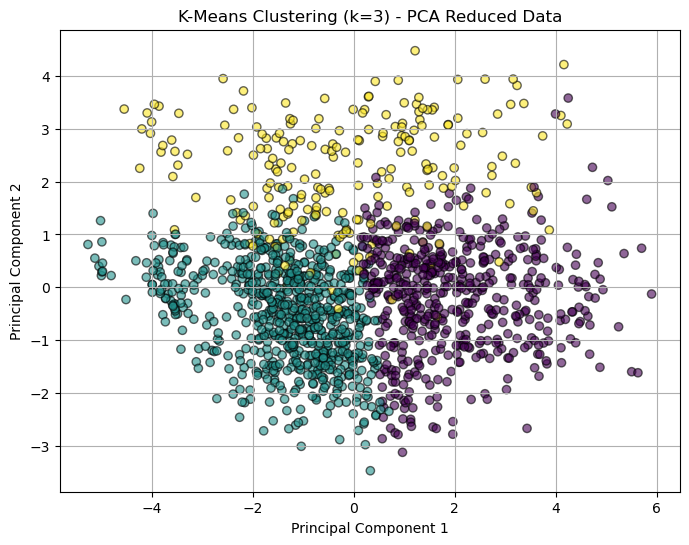

In [311]:
# Optimal K=4

optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(df_pca)

pca_2d = df_pca[:, :2]
# Visualize Clustering Results Using Top 2 Components
plt.figure(figsize=(8, 6))
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=clusters, cmap='viridis', alpha=0.6, edgecolors='k')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title(f"K-Means Clustering (k={optimal_k}) - PCA Reduced Data")
plt.grid()
plt.show()

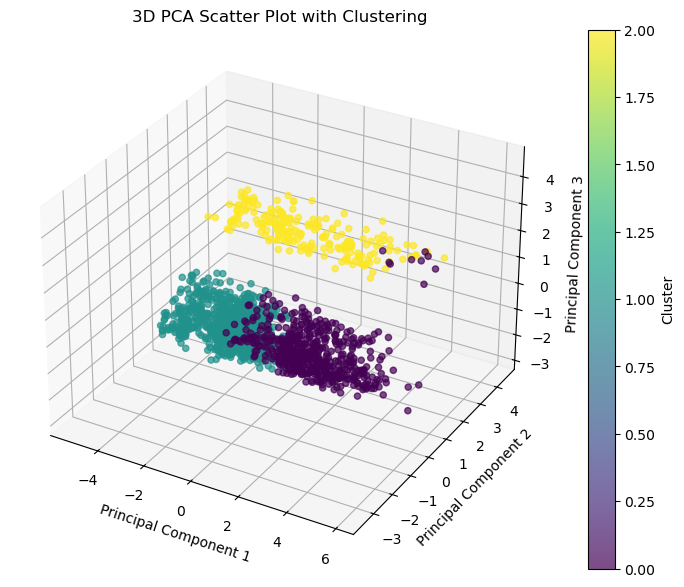

In [312]:
from mpl_toolkits.mplot3d import Axes3D

pca_3d = df_pca[:, :3]

# Plot 3D PCA Scatter Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_3d[:, 0], pca_3d[:, 1], pca_3d[:, 2], c=clusters, cmap='viridis', alpha=0.7)

ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.set_title("3D PCA Scatter Plot with Clustering")

plt.colorbar(scatter, ax=ax, label="Cluster")
plt.show()

In [333]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(df_pca)

silhouette_avg = silhouette_score(df_pca, clusters)
silhouette_avg

0.11010380302583932

In [420]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(df_pca)

# Calculate Attrition Rate for Each Cluster
attrition_rates = df.groupby("Cluster")["Attrition"].value_counts(normalize=True).unstack() * 100
attrition_rates

Attrition,No,Yes
Cluster,,
0,90.211132,9.788868
1,79.644809,20.355191
2,82.949309,17.050691


In [422]:
df_clustering = df.copy()
df_count = df_clustering.groupby(by=["Cluster"]).size().reset_index(name="counts")
df_count

,Cluster,counts
0,0,521
1,1,732
2,2,217


## **Agglomerative Clustering**

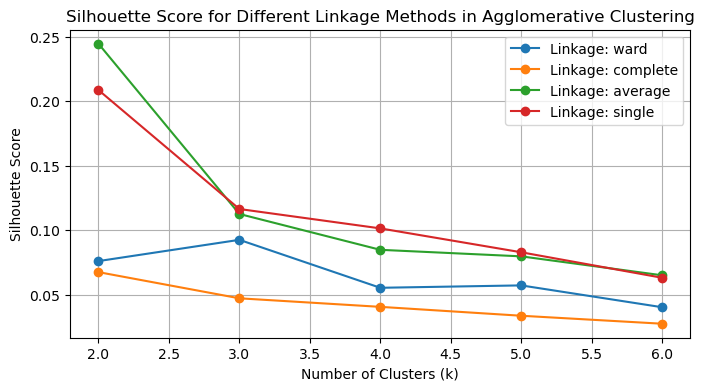

In [314]:
# Try Different Linkage Methods
linkage_methods = ["ward", "complete", "average", "single"]

# k range
cluster_range = range(2, 7)

silhouette_scores = {method: [] for method in linkage_methods}

# Calculate Silhouette Score
for method in linkage_methods:
    for k in cluster_range:
        agglo = AgglomerativeClustering(n_clusters=k, linkage=method)
        clusters = agglo.fit_predict(df_pca)
        score = silhouette_score(df_pca, clusters)
        silhouette_scores[method].append(score)

# Plot Silhouette Score for Different Linkage Methods
plt.figure(figsize=(8, 4))
for method in linkage_methods:
    plt.plot(cluster_range, silhouette_scores[method], marker='o', linestyle='-', label=f"Linkage: {method}")

plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different Linkage Methods in Agglomerative Clustering")
plt.legend()
plt.grid()
plt.show()

## **DBSCAN**

In [103]:
dbscan_eps = [2.0, 3.0, 4.0, 5.0]  
dbscan_scores_pca = {}

for eps in dbscan_eps:
    dbscan = DBSCAN(eps=eps, min_samples=10)
    dbscan_clusters = dbscan.fit_predict(df_pca)
    
    # Count number of clusters selected (Exclude -1 which is noise)
    num_clusters = len(set(dbscan_clusters)) - (1 if -1 in dbscan_clusters else 0)
    
    print(f"eps = {eps}: Number of clusters (k) = {num_clusters}")

eps = 2.0: Number of clusters (k) = 0
eps = 3.0: Number of clusters (k) = 0
eps = 4.0: Number of clusters (k) = 1
eps = 5.0: Number of clusters (k) = 1


## **Mean Shift**

In [104]:
from sklearn.cluster import MeanShift
from sklearn.metrics import silhouette_score

mean_shift = MeanShift()
mean_shift_clusters = mean_shift.fit_predict(df_pca)

# K value
num_clusters = len(set(mean_shift_clusters)) - (1 if -1 in mean_shift_clusters else 0)

# Calculate silhouette score
if num_clusters > 1:
    mean_shift_score = silhouette_score(df_pca, mean_shift_clusters)
else:
    mean_shift_score = -1 # Ensure at least 2 clusters

print(f"Number of clusters (k) = {num_clusters}, Silhouette Score = {mean_shift_score:.4f}")

Number of clusters (k) = 1, Silhouette Score = -1.0000


In [316]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(data_log_encoded_std_pca)
print(f"Explained Variance Ratio: {sum(pca.explained_variance_ratio_):.4f}")

Explained Variance Ratio: 0.2347


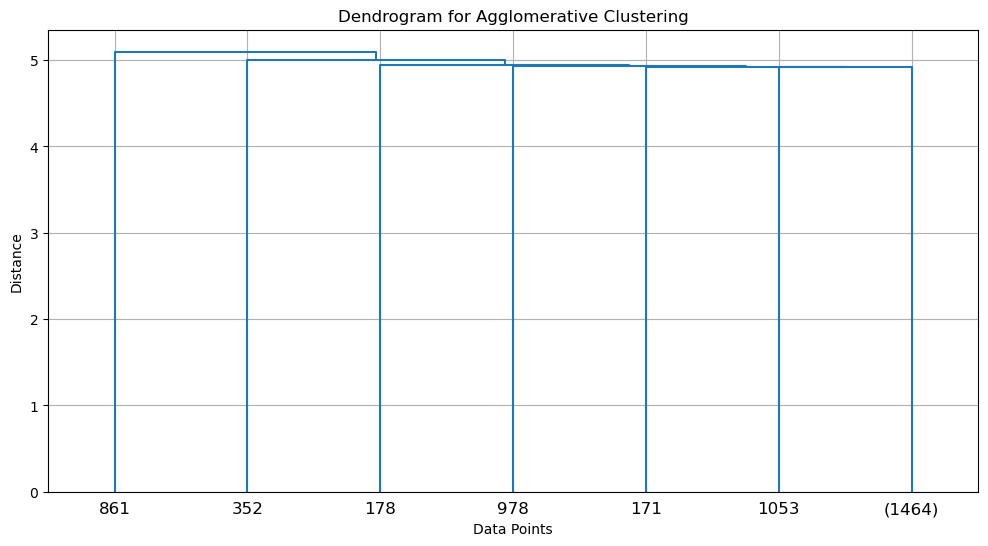

In [317]:
# Dendrogram for single linkage: Shows Error
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

linked = sch.linkage(df_pca, method="single")

plt.figure(figsize=(12, 6))
sch.dendrogram(linked, truncate_mode="level", p=5) 
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.title("Dendrogram for Agglomerative Clustering")
plt.grid()
plt.show()

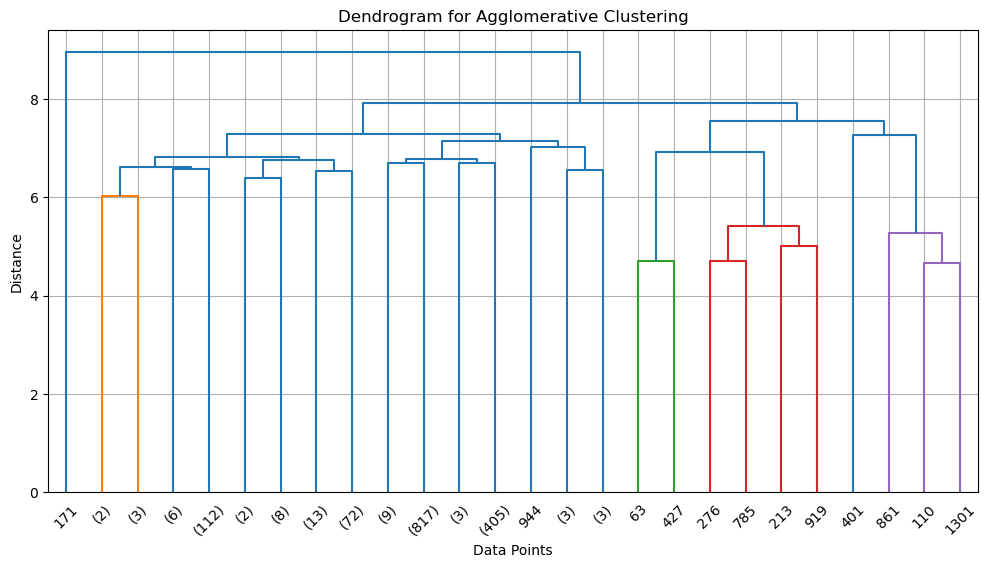

In [319]:
# Dendrogram
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

linked = sch.linkage(df_pca, method="average")

plt.figure(figsize=(12, 6))
sch.dendrogram(linked, truncate_mode="level", p=5)  # p 控制显示的层级（减少混乱）
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.title("Dendrogram for Agglomerative Clustering")
plt.grid()
plt.show()

In [327]:
from sklearn.cluster import AgglomerativeClustering

# Agglomerative Clustering (k=3, Average Linkage)
agglo = AgglomerativeClustering(n_clusters=3, linkage='average')
df["Cluster"] = agglo.fit_predict(df_pca)

# Calculate Attrition Rate for Each Cluster
attrition_rates = df.groupby("Cluster")["Attrition"].value_counts(normalize=True).unstack() * 100
attrition_rates = attrition_rates.fillna(0)  # Fill NaN by 0

In [329]:
# Print Silhouette Score
agglo = AgglomerativeClustering(n_clusters=3, linkage='average')
clusters = agglo.fit_predict(df_pca)

silhouette_avg = silhouette_score(df_pca, clusters)
silhouette_avg

0.11268617474647517

In [330]:
df_clustering = df.copy()
df_count = df_clustering.groupby(by=["Cluster"]).size().reset_index(name="counts")
df_count

,Cluster,counts
0,0,10
1,1,1
2,2,1459


## **Spectral Clustering**

In [332]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

spectral = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', random_state=42)
clusters = spectral.fit_predict(df_pca)

silhouette_avg = silhouette_score(df_pca, clusters)
silhouette_avg

0.10920724518745775

## **Final Clustering Technique: KMeans**

In [403]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(df_pca)

# Calculate Attrition Rate for Each Cluster
attrition_rates = df.groupby("Cluster")["Attrition"].value_counts(normalize=True).unstack() * 100
attrition_rates = attrition_rates.fillna(0)  # Fill NaN by 0

df_clustering = df.copy()
df_count = df_clustering.groupby(by=["Cluster"]).size().reset_index(name="counts")
df_count

,Cluster,counts
0,0,521
1,1,732
2,2,217


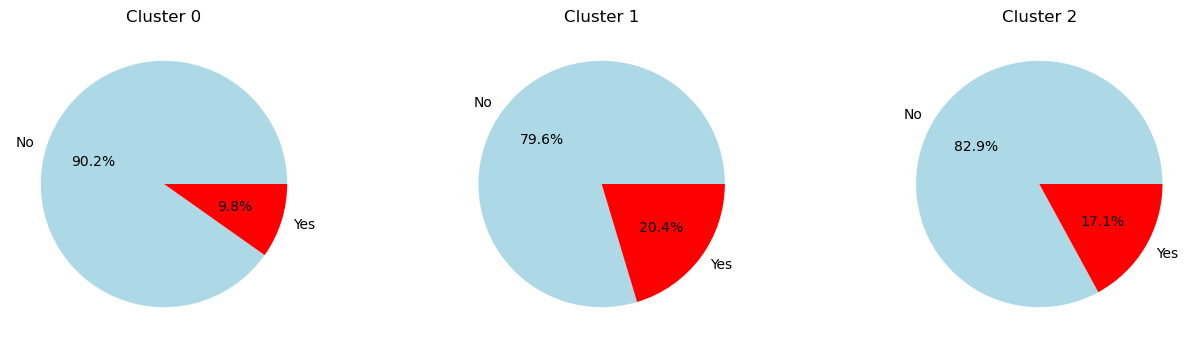

In [427]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for i, cluster in enumerate(attrition_rates.index):
    axes[i].pie(attrition_rates.loc[cluster], labels=attrition_rates.columns, autopct='%1.1f%%', colors=['lightblue', 'red'])
    axes[i].set_title(f"Cluster {cluster}")

plt.show()


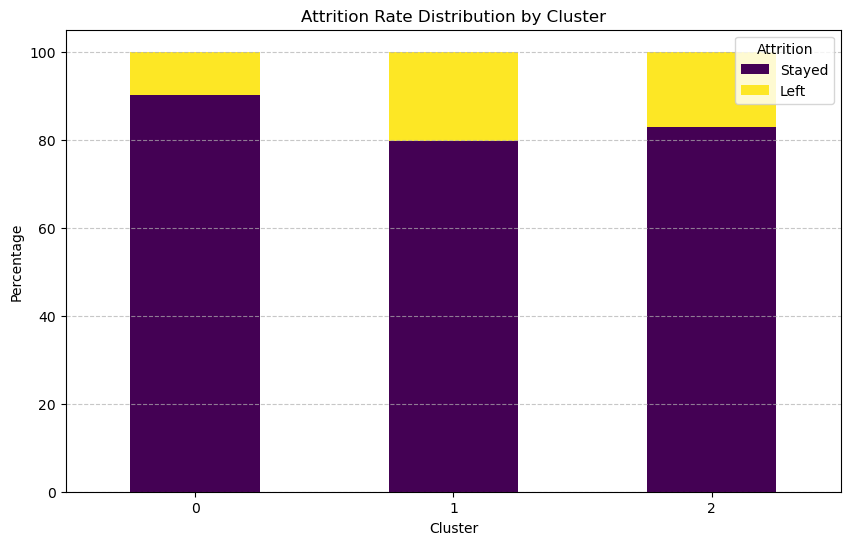

In [339]:
import matplotlib.pyplot as plt

attrition_rates.plot(kind='bar', stacked=True, figsize=(10, 6), colormap="viridis")

plt.xlabel("Cluster")
plt.ylabel("Percentage")
plt.title("Attrition Rate Distribution by Cluster")
plt.legend(title="Attrition", labels=["Stayed", "Left"])
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [183]:
df["Attrition"].value_counts(normalize=True)

Attrition
No     0.838776
Yes    0.161224
Name: proportion, dtype: float64

In [346]:
import pandas as pd
from scipy.stats import f_oneway, kruskal
import numpy as np

# Put Attrition Back to df1
df1 = pd.concat([df[['Attrition']], data], axis=1)
df1['Attrition'] = pd.get_dummies(df1['Attrition'], drop_first = True)

# Ensure Cluster is categorical
df1["Cluster"] = df["Cluster"].astype("category")

anova_results = {}

for feature in df1.drop(columns=["Cluster"]).columns:
    groups = [df1[df1["Cluster"] == c][feature].dropna() for c in df1["Cluster"].unique()]
    
    # **检查特征是否所有值相同**
    if all(g.nunique() == 1 for g in groups):  
        print(f"Skipping {feature}: All values are identical across clusters")
        continue
    
    # **确保每个 Cluster 里有足够的数据**
    if all(len(g) > 1 for g in groups):  
        try:
            p_value = kruskal(*groups).pvalue  # Kruskal-Wallis 检验
            anova_results[feature] = p_value
        except ValueError as e:
            print(f"Skipping {feature} due to error: {e}")

# **转换成 DataFrame 并按 P 值排序**
anova_results = pd.DataFrame(anova_results.items(), columns=["Feature", "P-Value"])
anova_results = anova_results.sort_values(by="P-Value")

anova_results

,Feature,P-Value
20,PerformanceRating,5.785107e-305
26,YearsAtCompany,9.114496e-167
27,YearsInCurrentRole,6.016167e-144
29,YearsWithCurrManager,4.585594e-136
19,PercentSalaryHike,2.467417e-121
23,TotalWorkingYears,4.519319e-120
15,MonthlyIncome,2.352468e-80
28,YearsSinceLastPromotion,4.577568e-74
1,Age,4.020370e-41
0,Attrition,3.250127e-06


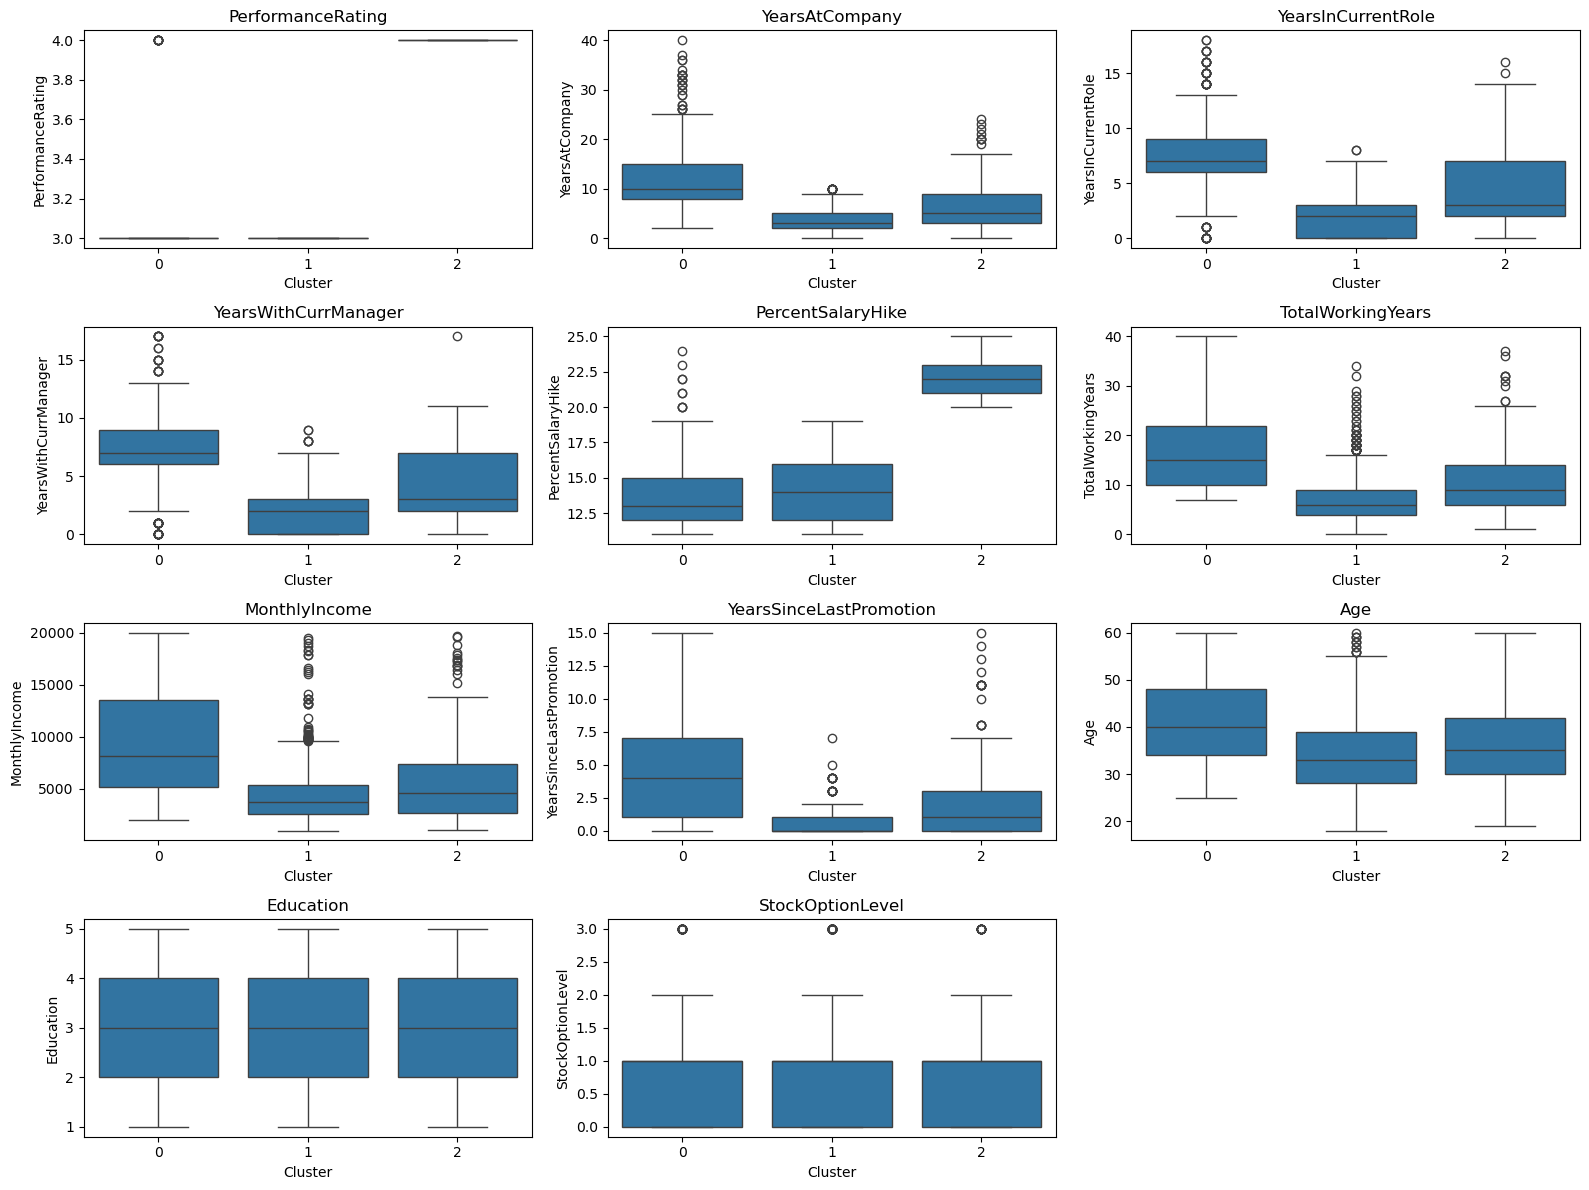

In [350]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Select P < 0.05 Features
significant_features = anova_results[anova_results["P-Value"] < 0.05]["Feature"].tolist()
significant_numeric = [feat for feat in significant_features if feat not in ['Attrition', 'MaritalStatus']]

fig, axes = plt.subplots(4, 3, figsize=(16, 12)) 
axes = axes.flatten()

# Boxplot
for i, feature in enumerate(significant_numeric):
    sns.boxplot(x=df1["Cluster"], y=df1[feature], ax=axes[i])
    axes[i].set_title(feature)
    
for j in range(i + 1, len(axes)):  
    fig.delaxes(axes[j])  

plt.tight_layout()
plt.show()

C:\Users\Yuriii\AppData\Local\Temp\ipykernel_5108\150268116.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df1, x=feature, hue="Cluster", fill=True, common_norm=False, ax=ax)


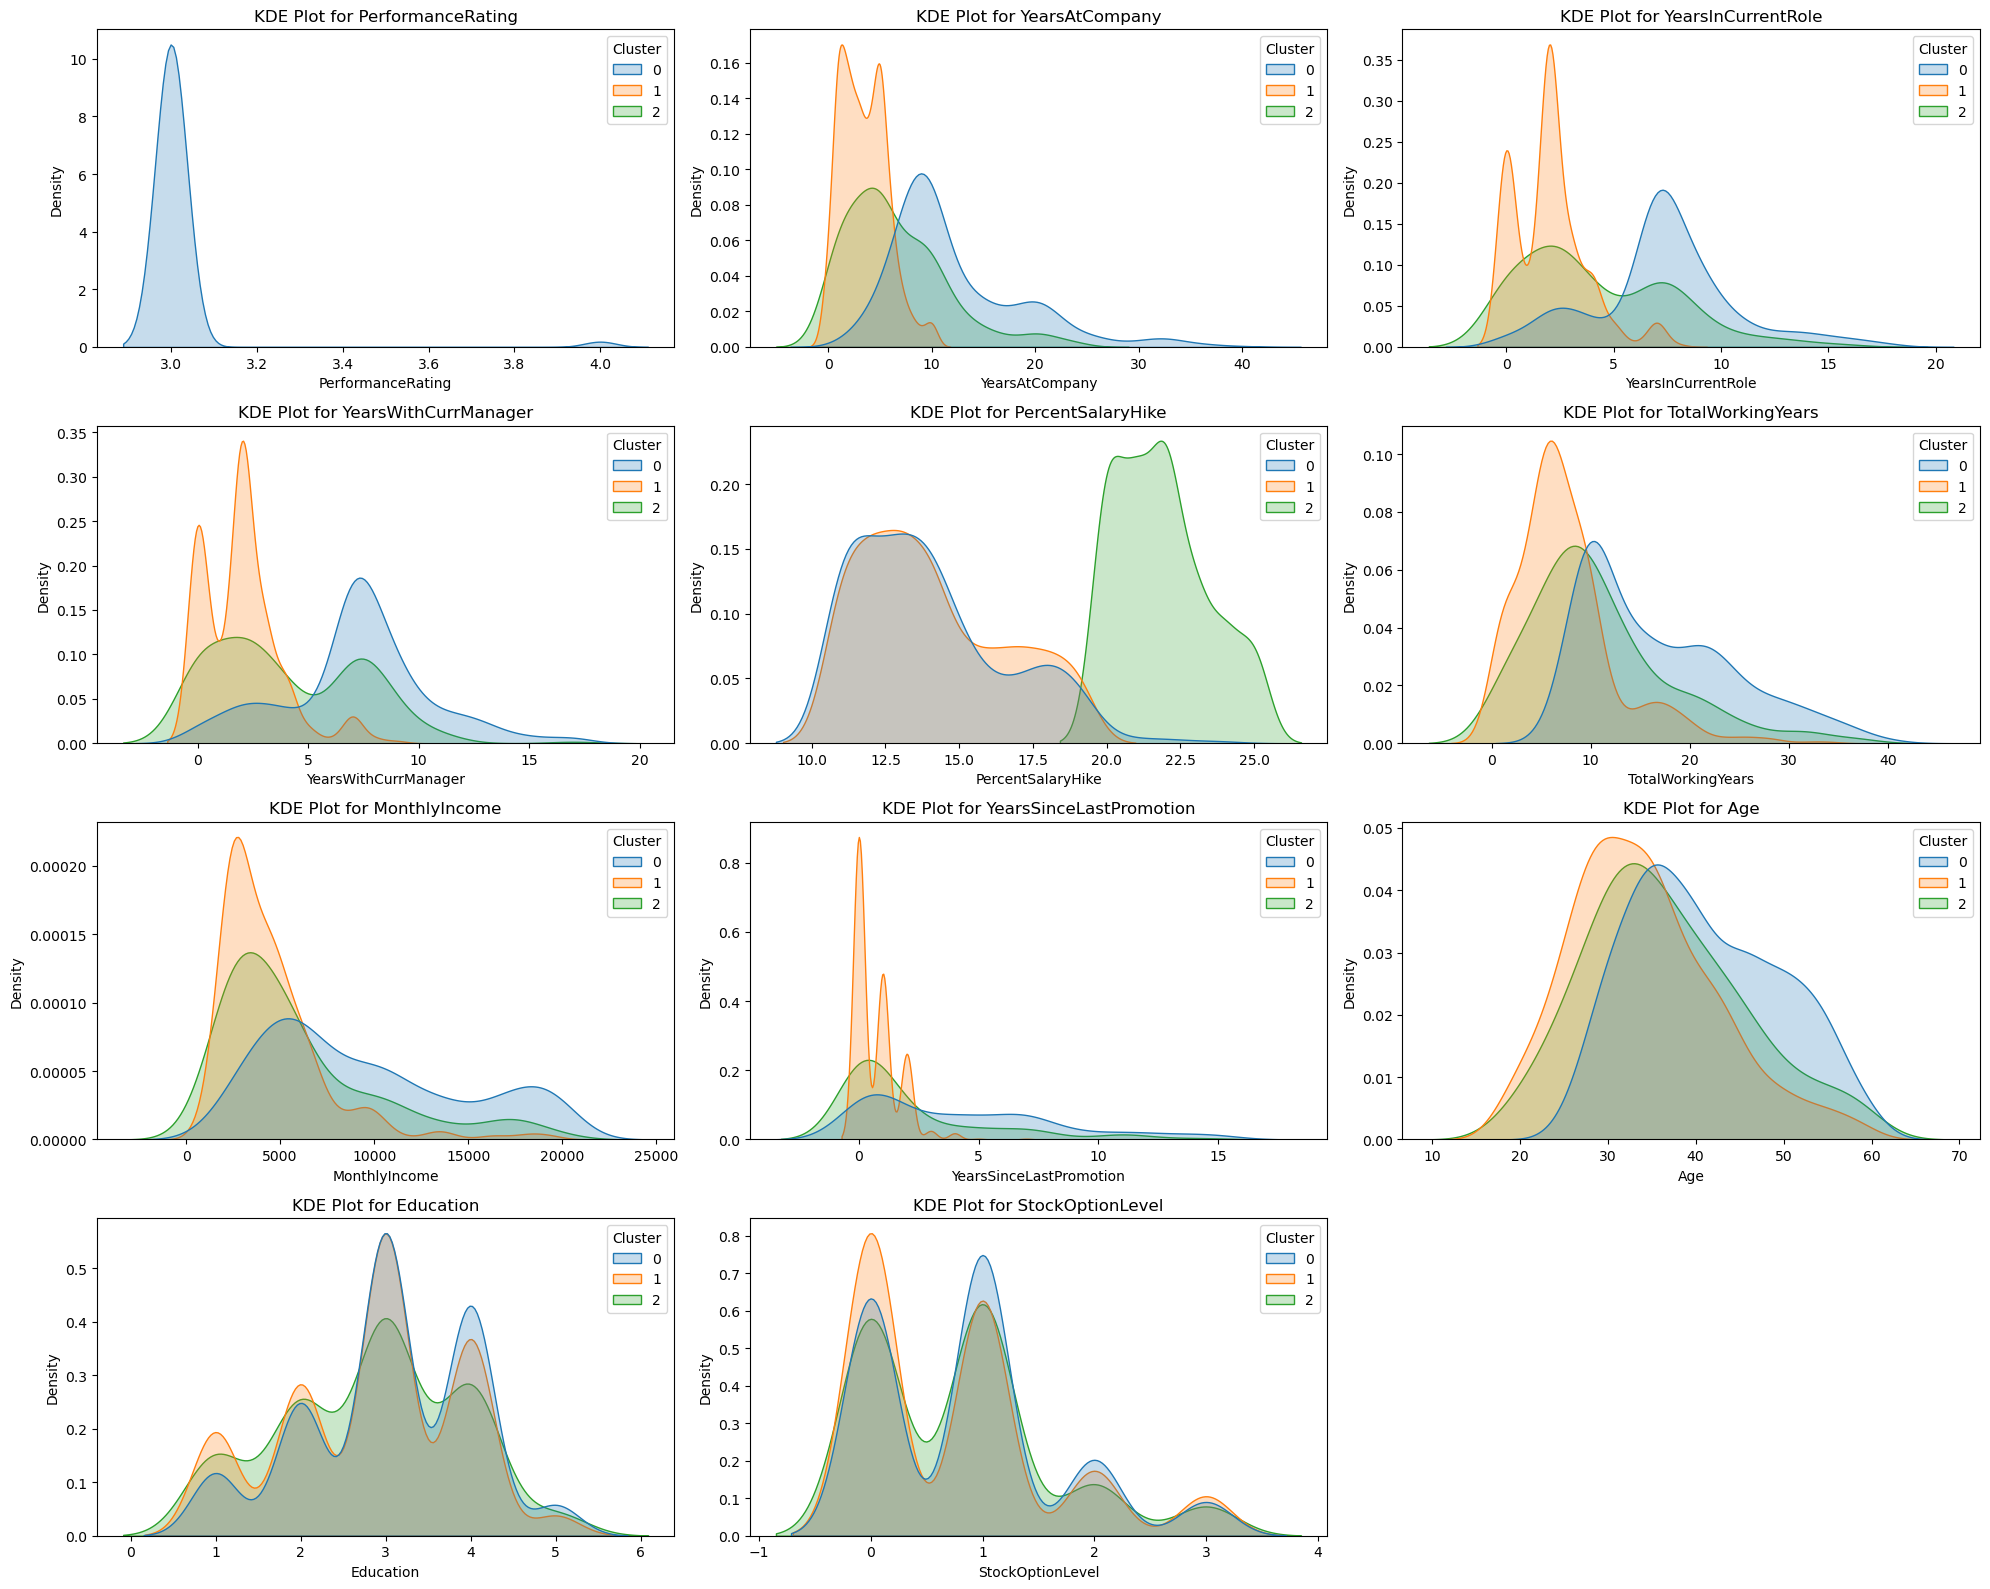

In [351]:
n_cols = 3
n_rows = 4

fig, axes = plt.subplots(4, 3, figsize=(20, 16))

# KDE Plot
for i, feature in enumerate(significant_numeric):
    row, col = divmod(i, n_cols)
    ax = axes[row, col] if n_rows > 1 else axes[col]
    
    sns.kdeplot(data=df1, x=feature, hue="Cluster", fill=True, common_norm=False, ax=ax)
    ax.set_title(f"KDE Plot for {feature}")

for j in range(i + 1, 4 * 3):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

C:\Users\Yuriii\AppData\Local\Temp\ipykernel_5108\2410643051.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_counts = df1.groupby(["Cluster", feature]).size().unstack()
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_5108\2410643051.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_counts = df1.groupby(["Cluster", feature]).size().unstack()


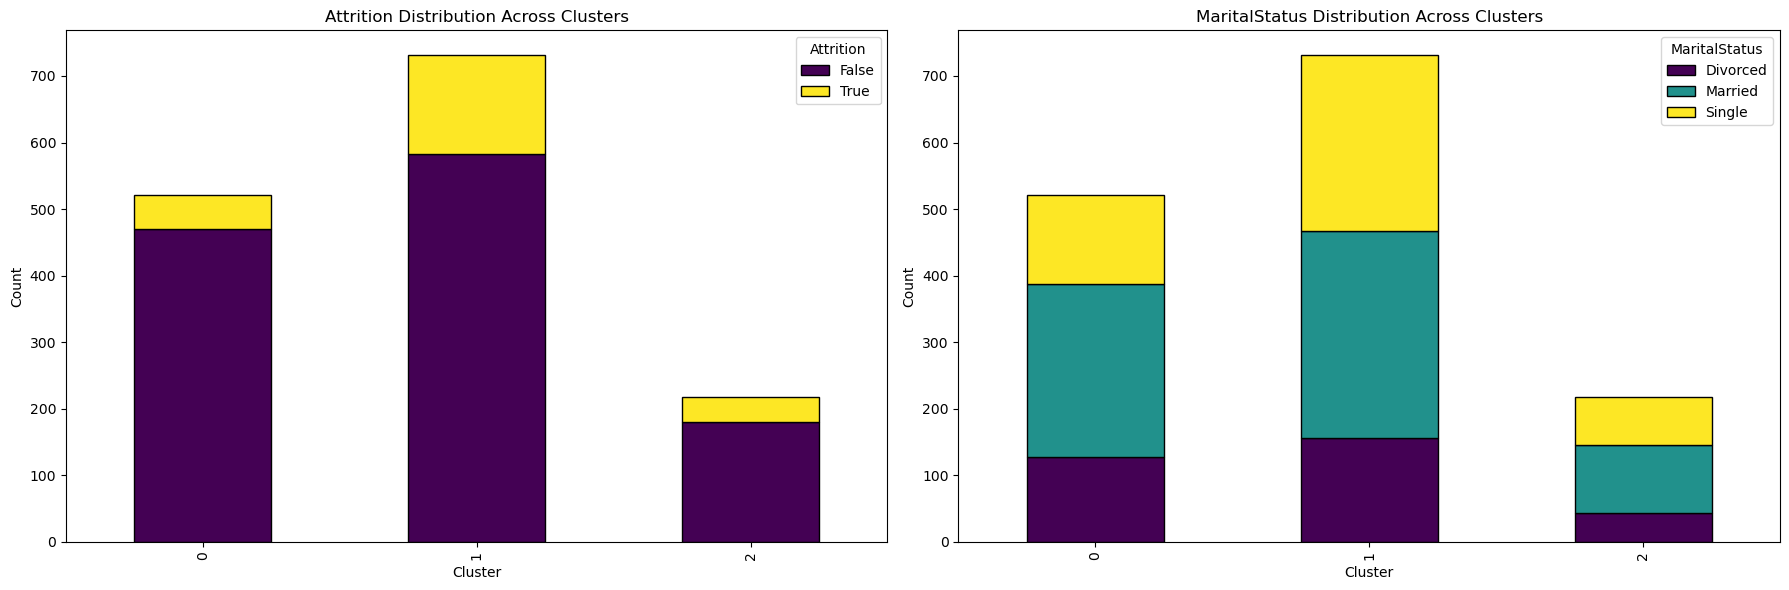

In [352]:
sig_categorical = ['Attrition', 'MaritalStatus']

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Stacked Bar Chart
for i, feature in enumerate(sig_categorical):
    ax = axes[i]
    
    # 计算每个 Cluster 内不同类别的计数
    cluster_counts = df1.groupby(["Cluster", feature]).size().unstack()

    # 画堆叠柱状图
    cluster_counts.plot(kind="bar", stacked=True, ax=ax, colormap="viridis", edgecolor="black")
    
    # 设置标题
    ax.set_title(f"{feature} Distribution Across Clusters")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Count")
    ax.legend(title=feature)

plt.tight_layout()
plt.show()

In [353]:
from scipy.stats import chi2_contingency

# 计算 Attrition 在不同 Cluster 的分布
attrition_table = pd.crosstab(df1["Cluster"], df1["Attrition"])

# 进行卡方检验
chi2, p, dof, expected = chi2_contingency(attrition_table)

print(f"Chi-Square Test P-Value for Attrition: {p}")

Chi-Square Test P-Value for Attrition: 3.2222887495604383e-06


## **Result Visualization**

In [424]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=df_pca.columns)
centroids

,YearsAtCompany,PerformanceRating,PercentSalaryHike,StockOptionLevel,JobSatisfaction,WorkLifeBalance,DistanceFromHome,EnvironmentSatisfaction,TrainingTimesLastYear,RelationshipSatisfaction,...,WorkLifeBalance,DistanceFromHome,HourlyRate,Education,NumCompaniesWorked,NumCompaniesWorked,YearsSinceLastPromotion,Age,EducationField_Life Sciences,BusinessTravel_Travel_Rarely
0,1.984959,-0.204735,-0.495977,0.008155,0.058418,-0.006086,0.024478,-0.011924,0.017184,0.059364,...,-0.048310,-0.000053,-0.000887,-0.017902,0.000337,-0.027872,0.006417,0.017956,0.027432,-0.010413
1,-1.367864,-0.508537,-0.223250,0.025144,-0.010292,0.003714,0.022251,0.038577,0.000796,-0.039782,...,0.048925,0.018311,-0.016583,0.009635,-0.006059,0.007510,-0.005805,-0.010258,-0.022023,0.003777
2,-0.151555,2.206987,1.943885,-0.104396,-0.105540,0.002084,-0.133828,-0.101503,-0.043940,-0.008333,...,-0.049050,-0.061640,0.058070,0.010480,0.019631,0.041585,0.004174,-0.008509,0.008428,0.012259


In [410]:
top_features = centroids.abs().idxmax(axis=1)
centroids_df = centroids.copy()
centroids_df["Key Feature"] = top_features

In [413]:
centroids_df["Key Feature"]

0       YearsAtCompany
1       YearsAtCompany
2    PerformanceRating
Name: Key Feature, dtype: object

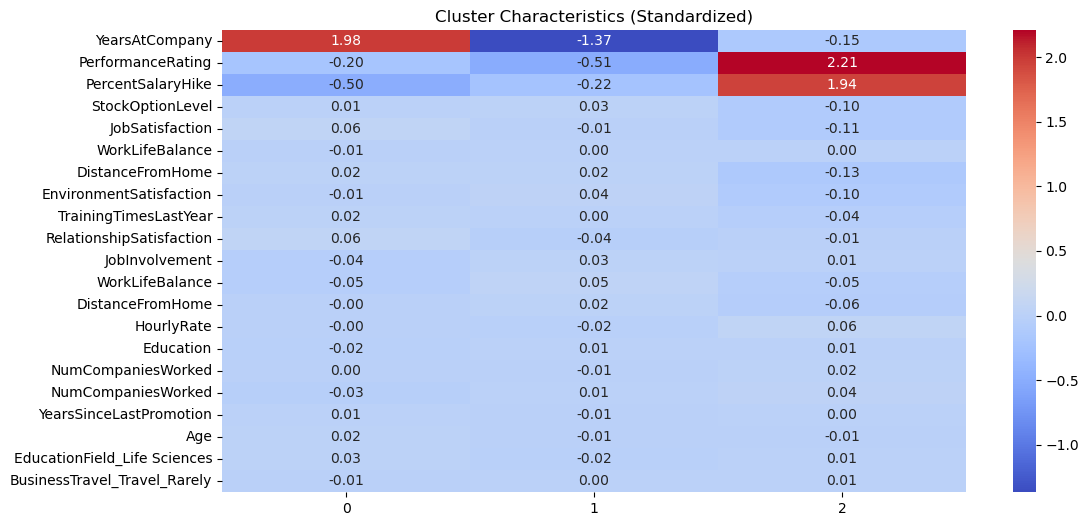

In [412]:
plt.figure(figsize=(12, 6))
sns.heatmap(centroids.T, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Cluster Characteristics (Standardized)")
plt.show()

### **Heatmap Interpretation Note**
From the heatmap, we can see the standardized means (Z-scores) for each cluster across different features.  
- **A Z-score > 0** means the feature value is **higher than the average** for that cluster.
- **A Z-score < 0** means the feature value is **lower than the average** for that cluster.

In [423]:
df_clustering = df.copy()
df_count = df_clustering.groupby(by=["Cluster"]).size().reset_index(name="counts")
df_count

,Cluster,counts
0,0,521
1,1,732
2,2,217


In [415]:
attrition_rates

Attrition,No,Yes
Cluster,,
0,90.211132,9.788868
1,79.644809,20.355191
2,82.949309,17.050691


### **Cluster Characteristics**

### **Cluster 0**
**Key Characteristics (High Z-scores)**
- YearsAtCompany (1.98): These employees have been with the company for a long time.
- PercentSalaryHike (-0.50): Their salary increase is below average.
- PerformanceRating (-0.20): Their performance ratings are slightly lower than other clusters.

**Business Insights**
- This cluster represents long-tenured employees who have stayed at the company for a significant period.
- Salary growth is relatively low, which could indicate limited career progression opportunities.
- Since performance ratings are slightly lower, they might be experiencing burnout or reduced motivation.

**Attrition Impact**
- Lowest attrition rate (9.78%) indicates that these employees are more likely to stay with the company, possibly due to job security, familiarity, or high switching costs.

**HR/Management Recommendations**
Focus on career growth opportunities**—if these employees feel stuck, they might leave in the future.  
Offer skill development programs and new responsibilities** to keep them engaged and productive.

---

### **Cluster 1**
**Key Characteristics (High Z-scores)**
- PerformanceRating (2.21): These employees have the highest performance ratings.
- PercentSalaryHike (1.94): They also receive the largest salary increases.
- StockOptionLevel (0.03): Their stock option levels are slightly higher than other clusters.

**Business Insights**
- This cluster consists of high-performing employees who are likely top talent in the company.
- Since salary growth is high, the company is actively rewarding them, which suggests they are critical contributors.
- However, this cluster has the highest attrition rate (20.35%), meaning that despite receiving salary increases, they are still leaving.

**Attrition Impact**
- Highest attrition rate (20.35%) could be opportunity-driven attrition, which means:
  - These employees have high market value and can easily find better opportunities.
  - They might have higher career aspirations that the company is not fulfilling.

**HR/Management Recommendations**
Salary increases alone are not enough to retain top talent, career advancement, challenging assignments, and leadership roles are crucial.  
Implement high-potential leadership programs and structured career progression plans.  
Use "Stay Interviews" to understand their long-term career goals and proactively address their concerns.

---

### **Cluster 2**
Key Characteristics (High Z-scores)
- PerformanceRating (-1.37): These employees have the lowest performance ratings.
- PercentSalaryHike (-0.22): Their salary increases are slightly below average.
- YearsAtCompany** (-0.15): They have the shortest tenure in the company.

**Business Insights**
- This cluster likely represents new or struggling employees:
  - They are relatively new to the company and still adjusting.
  - Their performance ratings are low, indicating either a lack of skills, engagement issues, or misalignment with the role.
  - Their salary increase is slightly below average, suggesting limited investment from the company.

**Attrition Impact**
- Moderate attrition rate (17.05%), higher than Cluster 0 but lower than Cluster 1.
- Their attrition is likely due to early-stage job dissatisfaction, lack of career direction, or feeling they are not a good fit.

**HR/Management Recommendations**
Strengthen career development and performance management for new employees.  
Implement a mentorship program** to accelerate their learning and integration into the company.  
Consider job rotation to see if they are better suited for different roles.

## **Overall Business Strategy**
**Cluster 0 (Long-tenured employees)**
   - They are stable for now, but if salary growth remains low, their attrition rate might rise in the future.
   - **HR should focus on career development and re-engagement programs**.

**Cluster 1 (High performers)**
   - **They have the highest attrition rate**, which is concerning because they are key contributors.
   - **HR should prioritize retention strategies beyond salary**, such as leadership development and career growth.

**Cluster 2 (Low-performing newcomers)**
   - Their attrition is likely due to **poor role fit or early job dissatisfaction**.
   - **Providing better onboarding, mentorship, and career coaching could improve retention**.